# Aprendizaje Profundo
Daniel López Gala - UO281798

Se dispone del conjunto de datos NIPS4BPLUS, el cual contiene 674 ficheros de audio con una duración total de menos de una hora. En estos audios podemos encontrar grabaciones de aproximadamente 5 segundos con cantos de pájaros realizadas en 39 localizaciones diferentes repartidas por 7 regiones de Francia y España.

In [1]:
base_path = "/content/drive/MyDrive/DeepLearning/"

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torchaudio
import torchaudio.transforms as T

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#!pip install scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split

In [2]:
def visualize_intermediates(intermediates, sample_rate=22050, hop_length=int(512 * 0.75)):

    # Set default background color for figures to white
    plt.rcParams['figure.facecolor'] = 'white'

    for key, value in intermediates.items():
        if len(value.shape) == 2 and value.shape[1] > 2:  # This indicates a waveform
            plt.figure(figsize=(12, 4))

            # Calculate time axis in seconds for waveform
            time_axis_waveform = np.linspace(0, value.shape[1] / sample_rate, value.shape[1])

            plt.plot(time_axis_waveform, value[0].cpu().numpy())
            plt.xlabel("Time (seconds)")
            plt.title(f"{key}")
            plt.show()
            continue

        print(f"Processing {key} with shape {value.shape}")

        if value.dim() == 4 and value.shape[-1] == 2:
            complex_representation = value[0, ..., 0] + 1j * value[0, ..., 1]  # Convert to complex
            magnitude = torch.abs(complex_representation).cpu().numpy()
            phase = torch.angle(complex_representation).cpu().numpy()
        elif value.is_complex():
            magnitude = torch.abs(value).squeeze().cpu().numpy()
            phase = torch.angle(value).squeeze().cpu().numpy()
        else:
            magnitude = value.squeeze().cpu().numpy()
            phase = None

        # Calculate time axis in seconds for magnitude
        time_axis_magnitude = np.linspace(0, magnitude.shape[1] * hop_length / sample_rate, magnitude.shape[1])

        # Plot magnitude with inverted grayscale colormap
        plt.figure(figsize=(12, 4))
        plt.imshow(magnitude, cmap='gray_r', aspect='auto', origin='lower', extent=[time_axis_magnitude[0], time_axis_magnitude[-1], 0, magnitude.shape[0]])
        plt.xlabel("Time (seconds)")
        plt.title(f"{key} Magnitude")
        plt.colorbar()
        plt.show()

        # Plot phase
        if phase is not None:
            plt.figure(figsize=(12, 4))
            plt.imshow(((phase + np.pi) % (2 * np.pi) - np.pi), cmap='hsv', aspect='auto', origin='lower', vmin=-np.pi, vmax=np.pi, extent=[time_axis_magnitude[0], time_axis_magnitude[-1], 0, phase.shape[0]])
            plt.xlabel("Time (seconds)")
            plt.title(f"{key} Phase")
            plt.colorbar()
            plt.show()


In [5]:
class AudioPreprocessing(nn.Module):
    def __init__(self, sample_rate=22050, n_fft=512, win_length=512, hop_length=int(512 * 0.75)):
        super(AudioPreprocessing, self).__init__()
        self.resampler = T.Resample(orig_freq=44100, new_freq=sample_rate)
        self.spectrogram = T.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=None, window_fn=torch.hann_window, center=False)

    def __call__(self, waveform):
        intermediates = {}  # Dictionary to store intermediate results

        # 1. Resample
        # waveform = self.resampler(waveform)
        # intermediates['resampled'] = waveform

        # 2. Apply STFT
        spectrogram = self.spectrogram(waveform)
        spectrogram = torch.abs(spectrogram)
        intermediates['stft'] = spectrogram

        # 3. Normalize
        max_val = spectrogram.max()
        if max_val:
            spectrogram /= max_val
        intermediates['normalized'] = spectrogram

        # # 4. Median Clipping
        # freq_median = torch.median(spectrogram, dim=2, keepdim=True)[0]
        # time_median = torch.median(spectrogram, dim=1, keepdim=True)[0]

        # mask = (spectrogram > (3 * freq_median)) & (spectrogram > (3 * time_median))
        # spectrogram = torch.where(mask, torch.tensor(1.0).to(spectrogram.device), torch.tensor(0.0).to(spectrogram.device))
        # intermediates['median_clipped'] = spectrogram

        # 5. Image processing techniques
        img = spectrogram.squeeze(0).cpu().numpy()
        # kernel = np.ones((3,3),np.uint8)
        # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        # img = cv2.dilate(img, kernel, iterations=1)
        # img = cv2.medianBlur(img, 3)
        # num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img.astype(np.uint8), 4, cv2.CV_32S)

        ##### 0.11
        # img = spectrogram.squeeze(0).cpu().numpy()
        # kernel_close = np.ones((3,3), np.uint8)
        # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_close)
        # kernel_dilate = np.ones((3,3), np.uint8)
        # img = cv2.dilate(img, kernel_dilate, iterations=1)
        # img = cv2.medianBlur(img, 3)
        # num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img.astype(np.uint8), 4, cv2.CV_32S)
        # Remove small components
        # for i in range(1, num_labels):
        #     if stats[i][-1] < 15:
        #         img[labels == i] = 0
        # intermediates['image_processed'] = torch.tensor(img).float().unsqueeze(0)
        #####

        ##### ?
        # Closing
        # img = spectrogram.squeeze(0).cpu().numpy()
        # kernel_close = np.ones((3,3), np.uint8)
        # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_close)
        # # Dilation
        # kernel_dilate = np.ones((3,3), np.uint8)
        # img = cv2.dilate(img, kernel_dilate, iterations=1)
        # # Median blur
        # img = cv2.medianBlur(img, 3)
        # intermediates['closing_and_dilation'] = torch.tensor(img).float().unsqueeze(0)
        # num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img.astype(np.uint8), 4, cv2.CV_32S)
        # # Remove small components
        # for i in range(1, num_labels):
        #     if stats[i][-1] < 8:
        #         img[labels == i] = 0
        intermediates['image_processed'] = torch.tensor(img).float().unsqueeze(0)
        #####

        return torch.tensor(img).float().unsqueeze(0), intermediates

In [6]:
class BirdSongDataset(Dataset):
    def __init__(self, df, audio_dir, class_info, transform=None):
        self.df = df
        self.audio_dir = audio_dir
        self.class_info = class_info
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx, 0]
        audio_path = os.path.join(self.audio_dir, filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        labels = self.df[self.df['filename'] == filename]
        target = torch.zeros(len(self.class_info))
        for _, label in labels.iterrows():
            class_name = label['class']
            target[self.class_info.index(class_name)] = 1.0

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, target

train_csv = pd.read_csv(f'{base_path}data/train.csv')
class_info_csv = pd.read_csv(f'{base_path}data/class_info.csv')
class_names = class_info_csv['class name'].tolist()

# Convert the labels to a binary matrix form
y = np.zeros((len(train_csv), len(class_names)))
for i, (_, row) in enumerate(train_csv.iterrows()):
    labels = row['class'].split(",")  # assuming classes are comma-separated
    for label in labels:
        y[i, class_names.index(label)] = 1

X_train, y_train, X_val, y_val = iterative_train_test_split(np.array(train_csv), y, test_size=0.1)

train_df = pd.DataFrame(X_train, columns=train_csv.columns)
valid_df = pd.DataFrame(X_val, columns=train_csv.columns)

transform = nn.Sequential(
    AudioPreprocessing()
)

train_dataset = BirdSongDataset(train_df, f'{base_path}data/train/', class_names, transform=transform)
valid_dataset = BirdSongDataset(valid_df, f'{base_path}data/train/', class_names, transform=transform)

In [7]:
def get_class_proportions(y, class_names):
    """
    Calculate the proportion of each class in the given binary matrix y.
    """
    proportions = {}
    total_samples = y.shape[0]

    for idx, class_name in enumerate(class_names):
        proportions[class_name] = np.sum(y[:, idx]) / total_samples

    return proportions


train_proportions = get_class_proportions(y_train, class_names)
valid_proportions = get_class_proportions(y_val, class_names)

# print("Class Proportions in Training Dataset:")
# for class_name, proportion in train_proportions.items():
#     print(f"{class_name}: {proportion * 100:.2f}%")

# print("\nClass Proportions in Validation Dataset:")
# for class_name, proportion in valid_proportions.items():
#     print(f"{class_name}: {proportion * 100:.2f}%")

# Comparing the differences in proportions
print("\nDifferences in Proportions (Training - Validation):")
for class_name in class_names:
    difference = train_proportions[class_name] - valid_proportions[class_name]
    print(f"{class_name}: {difference * 100:.2f}%")


Differences in Proportions (Training - Validation):
Aegcau_call: -0.05%
Alaarv_song: 0.02%
Anttri_song: 0.07%
Butbut_call: -0.07%
Carcan_call: -0.05%
Carcan_song: -0.03%
Carcar_call: 0.05%
Carcar_song: 0.07%
Cerbra_call: 0.12%
Cerbra_song: -0.10%
Cetcet_song: -0.13%
Chlchl_call: -0.07%
Cicatr_song: -0.07%
Cicorn_song: -0.02%
Cisjun_song: 0.05%
Colpal_song: -0.05%
Corcor_call: -0.07%
Denmaj_call: 0.05%
Denmaj_drum: -0.05%
Embcir_call: 0.07%
Embcir_song: 0.05%
Erirub_call: -0.10%
Erirub_song: 0.02%
Fricoe_call: -0.00%
Fricoe_song: 0.07%
Galcri_call: -0.07%
Galcri_song: -0.00%
Galthe_call: 0.05%
Galthe_song: -0.13%
Gargla_call: 0.05%
Hirrus_call: -0.10%
Jyntor_song: -0.02%
Lopcri_call: 0.05%
Loxcur_call: -0.10%
Lularb_song: 0.11%
Lusmeg_call: 0.10%
Lusmeg_song: -0.05%
Lyrple_song: 0.07%
Motcin_call: -0.08%
Musstr_call: -0.07%
Noise: 0.09%
Oriori_call: 0.07%
Oriori_song: -0.00%
Parate_call: -0.00%
Parate_song: -0.08%
Parcae_call: -0.12%
Parcae_song: -0.12%
Parmaj_call: 0.12%
Parmaj_song: 

torch.Size([1, 257, 574])
Number of positive labels: 2.0
Processing stft with shape torch.Size([1, 257, 574])


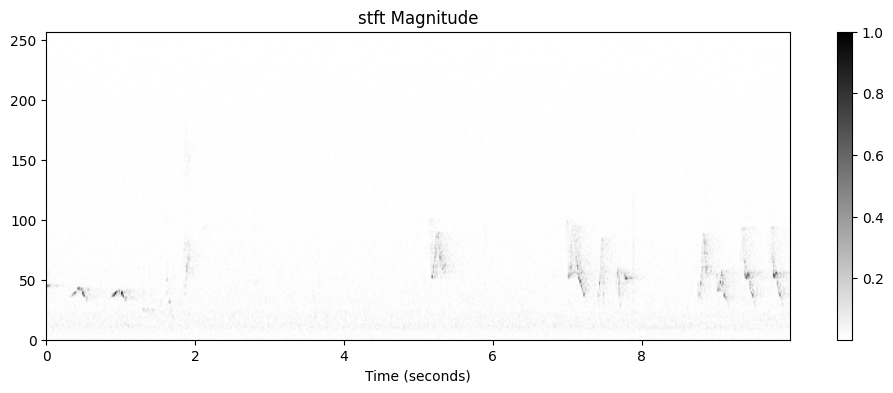

Processing normalized with shape torch.Size([1, 257, 574])


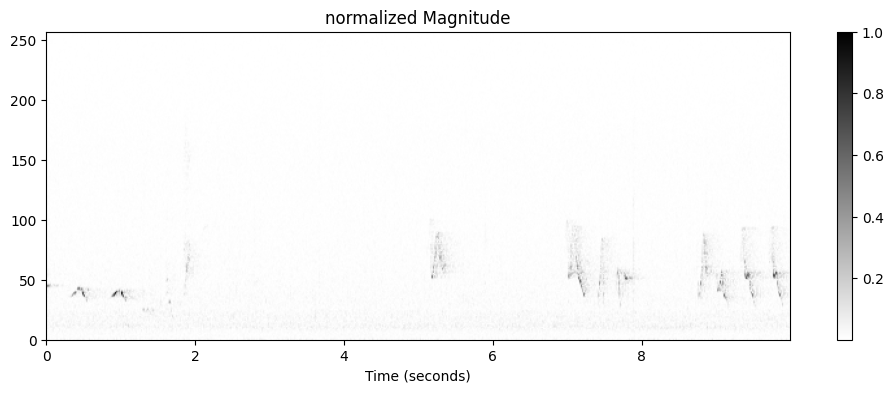

Processing image_processed with shape torch.Size([1, 257, 574])


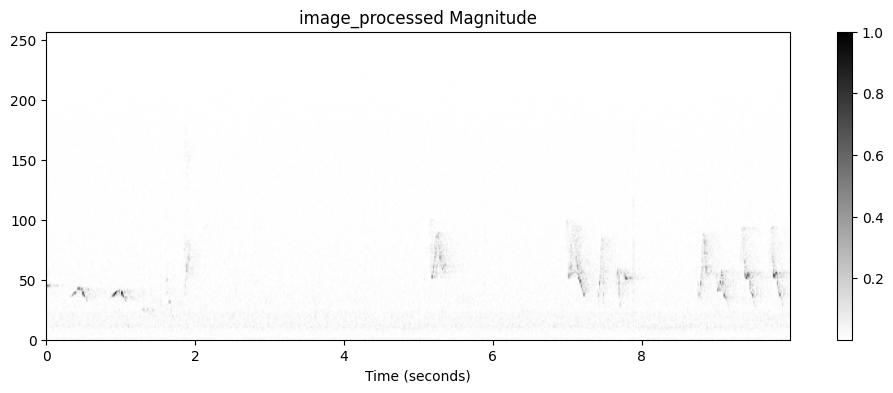

In [8]:
sample, target = train_dataset[75]
processed_sample, intermediates = sample

print(processed_sample.shape)
num_positive_labels = target.sum().item()
print(f"Number of positive labels: {num_positive_labels}")
visualize_intermediates(intermediates)

In [9]:
# Calculate the global max length of waveforms in the dataset
global_max_len = max(
    max(dataset[i][0][0].shape[2] for i in range(len(dataset)))
    for dataset in [train_dataset, valid_dataset]
)

In [10]:
def collate_fn(batch):
    # Test set scenario
    if isinstance(batch[0][1], str):
        waveforms, filenames = zip(*batch)
        # Directly pad and return, no need to stack targets
        waveforms = [torch.cat([wf[0], torch.zeros(wf[0].shape[0], wf[0].shape[1], global_max_len - wf[0].shape[2])], dim=2) for wf in waveforms]
        waveforms = torch.stack(waveforms)
        return waveforms, filenames

    # Training or validation batch
    waveforms, targets = zip(*batch)
    waveforms = [torch.cat([wf[0], torch.zeros((1, wf[0].shape[1], global_max_len - wf[0].shape[2]))], dim=2) for wf in waveforms]
    waveforms = torch.stack(waveforms)
    targets = torch.stack(targets)
    return waveforms, targets


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [11]:
class ResNetMultilabel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetMultilabel, self).__init__()
        # Load pre-trained resnet model
        self.resnet = models.resnet50(pretrained=True)

        # Modify the first convolutional layer to accept single-channel (grayscale) images
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Remove the last fully connected layer to adapt for our task
        layers = list(self.resnet.children())[:-1]
        self.features = nn.Sequential(*layers)

        # Custom classifier for our multilabel task
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [12]:
# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

# Initialize the model
model = ResNetMultilabel(num_classes=len(class_names)).to(device)
# Assuming the pre-trained layers are in a submodule named 'features'
for param in model.features.parameters():
    param.requires_grad = False


Using: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 62.4MB/s]


In [ ]:
# Use discriminative learning rates
base_lr = 0.001

optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': base_lr / 10}, # Discriminative learning rate for pre-trained layers
    {'params': model.classifier.parameters(), 'lr': base_lr} # Learning rate for the classifier
])


criterion = nn.BCELoss() # Loss for multilabel.
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

best_val_loss = float('inf')
best_f1 = float('-inf')
epochs_no_improve = 0
n_epochs_stop = 15
early_stop = False
thresholds = np.arange(0.1, 0.5, 0.05)

# num_epochs = 9 -> 0.28
num_epochs = 20
for epoch in range(num_epochs):

    # Unfreeze layers for fine-tuning after a certain number of epochs
    if epoch == 18:
        for param in model.features.parameters():
            param.requires_grad = True

    # Training
    model.train()
    running_train_loss = 0.0
    all_train_preds = []
    all_train_labels = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Store training predictions and true labels
        all_train_preds.extend(outputs.detach().cpu().numpy().tolist())
        all_train_labels.extend(labels.cpu().numpy().tolist())

    train_loss = running_train_loss / len(train_loader)

    # Calculate training F1 score
    train_f1_scores = []
    for threshold in thresholds:
        train_f1_scores.append(f1_score(all_train_labels, np.array(all_train_preds) > threshold, average='samples'))
    train_best_f1 = max(train_f1_scores)

    # Validation
    model.eval()
    running_val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            # Store predictions and true labels
            all_preds.extend(outputs.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    val_loss = running_val_loss / len(valid_loader)

    # Find the best threshold for F1 score
    f1_scores = []
    for threshold in thresholds:
        f1_scores.append(f1_score(all_labels, np.array(all_preds) > threshold, average='samples'))

    # Get the best F1 score and corresponding threshold
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    current_best_f1 = f1_scores[best_threshold_index]

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Training F1: {train_best_f1:.4f}, Validation Loss: {val_loss:.4f}, Best Validation F1: {current_best_f1:.4f} at threshold {best_threshold:.2f}") # <- Modified

    # Checkpointing
    if current_best_f1 > best_f1:
        best_f1 = current_best_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        early_stop = True
        break

    # Adjusting learning rate
    scheduler.step(-val_loss)  # Pass negative F1 score since ReduceLROnPlateau expects to minimize the metric

if early_stop:
    print("Stopped training. Loading best model weights!")
    model.load_state_dict(torch.load('best_model.pth'))

print('Finished Training')

Epoch 1, Train Loss: 0.1322, Training F1: 0.1069, Validation Loss: 0.0841, Best Validation F1: 0.1317 at threshold 0.10
Epoch 2, Train Loss: 0.1008, Training F1: 0.1930, Validation Loss: 0.0757, Best Validation F1: 0.2643 at threshold 0.10
Epoch 3, Train Loss: 0.0913, Training F1: 0.2554, Validation Loss: 0.0707, Best Validation F1: 0.2784 at threshold 0.15


In [ ]:
print(f"Best threshold: {best_threshold}")

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > best_threshold).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1_macro = f1_score(all_labels, all_preds, average='samples')
print(f"F1 Score (Samples): {f1_macro}")

In [ ]:
# Loading the test set
class BirdSongTestDataset(Dataset):
    def __init__(self, df, audio_dir, transform=None):
        self.df = df
        self.audio_dir = audio_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx, 0]
        #print(f"File: {filename}")
        audio_path = os.path.join(self.audio_dir, filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, filename  # Return both waveform and filename to match the expected shape

test_csv = pd.read_csv(f'{base_path}data/test.csv')

test_dataset = BirdSongTestDataset(test_csv, f'{base_path}data/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
sample, _ = test_dataset[99]
processed_sample, intermediates = sample

print(processed_sample.shape)
visualize_intermediates(intermediates)

In [ ]:
# Make predictions on test set
model.eval()
predictions = {}
with torch.no_grad():
    for inputs, filenames in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (outputs > best_threshold).float().cpu().numpy().astype(int)
        for fname, pred in zip(filenames, preds):
            predictions[fname] = pred

# Convert predictions to submission format
submission_df = pd.DataFrame.from_dict(predictions, orient='index', columns=class_names)
submission_df.reset_index(inplace=True)
submission_df.rename(columns={'index': 'filename'}, inplace=True)
submission_df.to_csv('submission.csv', index=False)